In [27]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, StratifiedKFold
from lofo import LOFOImportance, Dataset, plot_importance

from lightgbm import LGBMClassifier, LGBMRegressor

from xgboost import XGBClassifier

%matplotlib inline

In [28]:
# import data
data_df_1 = pd.read_csv("../../data/imputed_training_validation_1.csv")
data_df_2 = pd.read_csv("../../data/imputed_training_validation_2.csv")
data_df_3 = pd.read_csv("../../data/imputed_model_refinement.csv")

merged_df = pd.concat([data_df_1, data_df_2, data_df_3], axis=0) # Merge data frames


In [3]:
train_df = merged_df.filter(regex="vCnt|value|class|run")

In [29]:
train_df = merged_df

In [30]:
sensor_list = list(train_df.columns)
sensor_list.remove('class')
sensor_list.remove('run')
len(sensor_list)

247

In [31]:
# split a sequence into samples
def create_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)


In [32]:
def create_dataset_for_run(df, ws):
#     data_data = np.empty((0, ws * len(sensor_list))) # for 1D
#     data_data = np.empty((0, ws, len(sensor_list))) # for 2D
#     data_data = np.empty((0, len(sensor_list), ws)) # for 2D
#     label_data = np.empty((0, 1))

    sensors_df = df.filter(sensor_list)

    # Calculate seq of windows_size len
    seq = create_sequence(sensors_df.values, n_steps=ws)
#     seq = np.transpose(seq, axes=(0, 2, 1))
    seq_count = seq.shape[0]
    seq = seq.reshape((seq_count, -1)) # for 1D

    # add new seq to data_data array
#     data_data = np.vstack((data_data, seq))

    # Calculate RULS
    labels = df['class'].values[:seq_count]

    # add rul to rul_data array
#     rul_data = np.vstack((rul_data, ruls))

# TODO: What is RUL_Max in this context?

#     print ("Shape:", seq.shape, labels.shape)
    return seq, labels


 

In [33]:
# TODO: X_t, X_tp1, y_t, y_tp1 should be calculated per run.  
# TODO: Then should be merged into one X_t, X_tp1, y_t, y_tp1.
def create_datasets(df, ws):
    c = int(df.iloc[0]['class'])
    r = int(df.iloc[0]['run'])
    
#     print (c, r)
    
    sensor_data, label_data = create_dataset_for_run(df, ws)

    # Post Processing for the model

    # Padding for model input 
    padded_sensor_data = sensor_data.copy() #np.hstack((sensor_data, np.zeros((sensor_data.shape[0], 2)))) # for AE     

    # Calculate X(t) and X(t+1) for model input/output 
    X_t = padded_sensor_data[:]

    # Calculate y(t) and y(t+1) for model input/output 
    y_t = label_data[:]

    return pd.DataFrame(X_t) #, y_t


In [34]:
train_df['class'].unique()

array([ 0,  2,  3,  5,  7,  9,  4, 11, 12], dtype=int64)

In [35]:
cols1 = [ "_".join([str(c),str(0)]) for i, c in enumerate(sensor_list)]
cols2 = [ "_".join([str(c),str(1)]) for i, c in enumerate(sensor_list)]
cols = ['class'] + cols1 + cols2
len(cols)

495

In [36]:
ws = 2
new_df = train_df.groupby(['class', 'run']).apply(create_datasets, ws)
new_df.reset_index(inplace=True)
del new_df['level_2']
del new_df['run']
new_df.columns = cols

In [37]:
# extract a sample of the data
sample_df = new_df.sample(frac=0.5, random_state=42)
#sample_df.sort_values("run", inplace=True)

In [38]:
sample_df.head()

,class,CpuTemperature_vMax_0,CpuTemperature_vMin_0,CpuTemperature_vStd_0,CpuTemperature_value_0,DurationPickToPick_vCnt_0,DurationPickToPick_vFreq_0,DurationPickToPick_vMax_0,DurationPickToPick_vMin_0,DurationPickToPick_vStd_0,...,NumberFuseEstimated_vMin_na_1,NumberFuseEstimated_vStd_na_1,NumberFuseEstimated_vTrend_na_1,NumberFuseEstimated_value_na_1,SharpnessImage_vMax_na_1,SharpnessImage_vMin_na_1,SharpnessImage_vStd_na_1,SharpnessImage_vTrend_na_1,SharpnessImage_value_na_1,TemperatureThermoCam_vTrend_na_1
56622,12,60.75,53.50,2.013858,57.225,4.0,0.397630,3.355,3.113,0.090187,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
13676,0,55.50,48.25,2.418160,51.550,3.0,0.298369,3.311,3.050,0.107456,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3073,0,49.75,41.75,2.344675,43.700,3.0,0.298732,3.189,2.773,0.182034,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
15359,0,55.50,48.50,2.250139,51.825,3.0,0.298886,2.993,2.865,0.056576,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
32986,0,63.75,54.50,2.702314,57.350,4.0,0.398875,3.554,3.071,0.190991,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [39]:
# define the validation scheme
cv = KFold(n_splits=3, shuffle=True, random_state=42)
# cv = StratifiedKFold(n_splits=4, shuffle=False, random_state=0, )

In [40]:
sample_df.shape

(28936, 495)

In [41]:
# define the binary target and the features
dataset = Dataset(df=sample_df, target="class", features=[col for col in sample_df.columns if col != 'class'])

In [42]:
model = LGBMClassifier(objective='multiclassova', num_class=9)

In [43]:
# define the validation scheme and scorer. The default model is LightGBM
lofo_imp = LOFOImportance(dataset, cv=cv, model=model, scoring="f1_micro")

In [ ]:
# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

  0%|          | 0/494 [00:00<?, ?it/s]

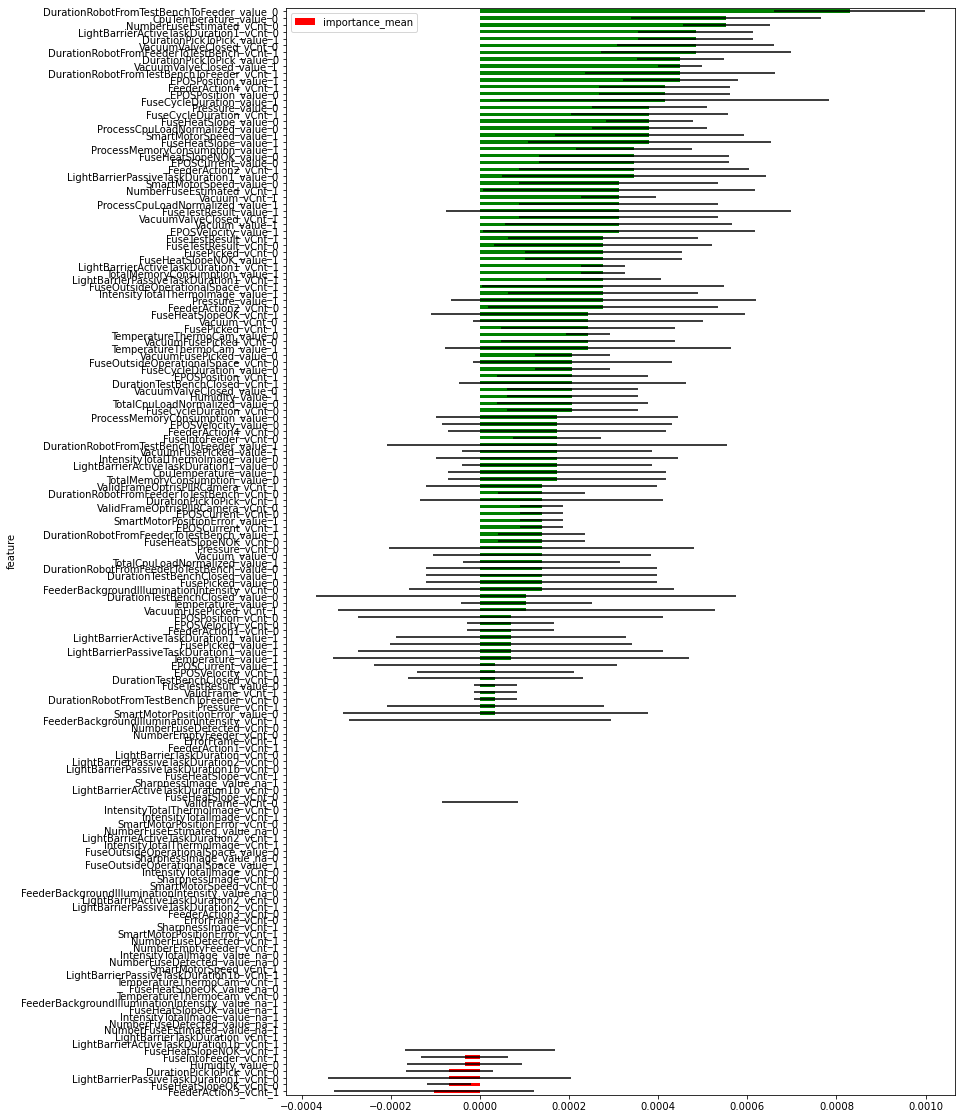

In [21]:
# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(12, 20))

In [22]:
len(set(sorted([x[:-2] for x in list(importance_df[importance_df.importance_mean>0].feature)])))

56

In [23]:
set(sorted([x[:-2] for x in list(importance_df[importance_df.importance_mean>0].feature)]))

{'CpuTemperature_value',
 'DurationPickToPick_vCnt',
 'DurationPickToPick_value',
 'DurationRobotFromFeederToTestBench_vCnt',
 'DurationRobotFromFeederToTestBench_value',
 'DurationRobotFromTestBenchToFeeder_vCnt',
 'DurationRobotFromTestBenchToFeeder_value',
 'DurationTestBenchClosed_vCnt',
 'DurationTestBenchClosed_value',
 'EPOSCurrent_vCnt',
 'EPOSCurrent_value',
 'EPOSPosition_vCnt',
 'EPOSPosition_value',
 'EPOSVelocity_vCnt',
 'EPOSVelocity_value',
 'FeederAction1_vCnt',
 'FeederAction2_vCnt',
 'FeederAction4_vCnt',
 'FeederBackgroundIlluminationIntensity_vCnt',
 'FuseCycleDuration_vCnt',
 'FuseCycleDuration_value',
 'FuseHeatSlopeNOK_vCnt',
 'FuseHeatSlopeNOK_value',
 'FuseHeatSlopeOK_vCnt',
 'FuseHeatSlope_value',
 'FuseIntoFeeder_vCnt',
 'FuseOutsideOperationalSpace_vCnt',
 'FusePicked_vCnt',
 'FusePicked_value',
 'FuseTestResult_vCnt',
 'FuseTestResult_value',
 'Humidity_value',
 'IntensityTotalThermoImage_value',
 'LightBarrierActiveTaskDuration1_vCnt',
 'LightBarrierActive